In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
import os
import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef
)
import xgboost as xgb


# ==========================================
# 1️⃣ Load Dataset
# ==========================================
df = pd.read_csv("/kaggle/input/stroke-prediction/healthcare-dataset-stroke-data.csv")

print("Dataset Shape:", df.shape)


# ==========================================
# 2️⃣ Data Preprocessing
# ==========================================

# Drop ID column
df = df.drop("id", axis=1)

# Fill missing BMI values
df["bmi"] = df["bmi"].fillna(df["bmi"].mean())

# Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


# ==========================================
# 3️⃣ Handle Imbalanced Data (Upsampling)
# ==========================================
df_majority = df[df.stroke == 0]
df_minority = df[df.stroke == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42)

print("Balanced Class Distribution:")
print(df_balanced["stroke"].value_counts())


# ==========================================
# 4️⃣ Split Features & Target
# ==========================================
X = df_balanced.drop("stroke", axis=1)
y = df_balanced["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ==========================================
# 5️⃣ Scaling
# ==========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")


# ==========================================
# 6️⃣ Define Models
# ==========================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss")
}


# ==========================================
# 7️⃣ Train & Evaluate
# ==========================================
results = []

print("\n===== Model Evaluation Metrics =====\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    auc = roc_auc_score(y_test, probas)
    mcc = matthews_corrcoef(y_test, preds)

    print(f"\n{name}")
    print("Accuracy :", acc)
    print("AUC      :", auc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1 Score :", f1)
    print("MCC      :", mcc)

    results.append([name, acc, auc, prec, rec, f1, mcc])

    joblib.dump(model, f"models/{name.replace(' ','_')}.pkl")


# ==========================================
# 8️⃣ Comparison Table
# ==========================================
comparison_df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "AUC", "Precision", "Recall", "F1 Score", "MCC"
])

print("\n===== Comparison Table =====\n")
print(comparison_df)


Dataset Shape: (5110, 12)
Balanced Class Distribution:
stroke
0    4861
1    4861
Name: count, dtype: int64

===== Model Evaluation Metrics =====


Logistic Regression
Accuracy : 0.7794344473007712
AUC      : 0.85233906065203
Precision: 0.7750730282375852
Recall   : 0.8008048289738431
F1 Score : 0.7877288471053934
MCC      : 0.5586441943937507

Decision Tree
Accuracy : 0.9665809768637532
AUC      : 0.9658254468980021
Precision: 0.9386213408876298
Recall   : 1.0
F1 Score : 0.9683390160740379
MCC      : 0.9351296226587864

KNN
Accuracy : 0.9377892030848329
AUC      : 0.9712681980420905
Precision: 0.8914798206278027
Recall   : 1.0
F1 Score : 0.9426268373636795
MCC      : 0.8820730356923732

Naive Bayes
Accuracy : 0.770694087403599
AUC      : 0.8314027170382972
Precision: 0.7729083665338645
Recall   : 0.7806841046277666
F1 Score : 0.7767767767767768
MCC      : 0.5410881783565389

Random Forest
Accuracy : 0.9933161953727506
AUC      : 1.0
Precision: 0.9870903674280039
Recall   : 1.0
F1 Scor

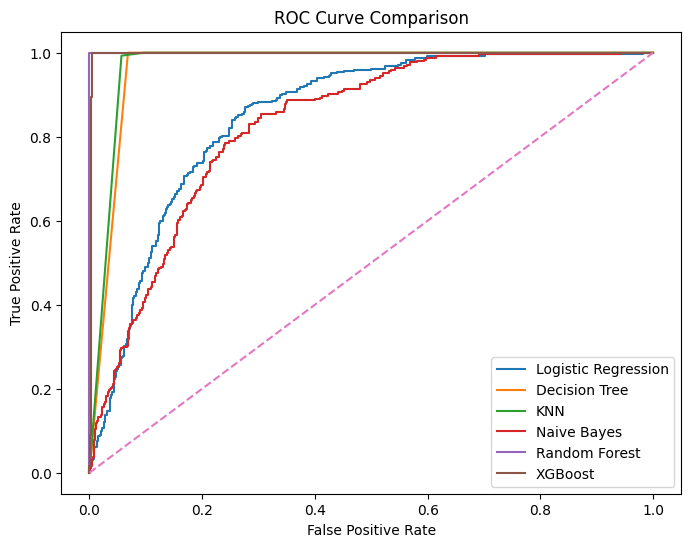

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))

for name, model in models.items():
    probas = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probas)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


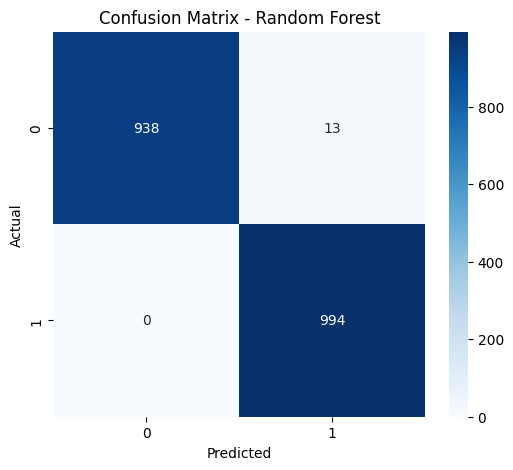

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

best_model_name = comparison_df.sort_values(
    by="F1 Score", ascending=False
).iloc[0]["Model"]

best_model = models[best_model_name]
preds = best_model.predict(X_test)

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
